<a href="https://colab.research.google.com/github/bderic1/StrojnoUcenje/blob/master/Mercari_Price_Suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [0]:
import functools
import warnings

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d.axes3d import Axes3D

#from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#from textblob import TextBlob
#import squarify 

%matplotlib inline
import pickle



In [0]:
#pip install ipython-autotime 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#loadanje stare konfiguracij
!pip install -r  "/content/gdrive/My Drive/Colab Notebooks/"Mercari_colab.txt""

In [3]:
cd gdrive/My Drive/"Colab Notebooks"

/content/gdrive/My Drive/Colab Notebooks


Učitavamo *train* podatakate te na njima radimo osnovnu analizu podataka.

In [0]:
data = pd.read_csv('train.tsv', sep='\t')


In [0]:

test=pd.read_csv('test.tsv', sep='\t')

In [0]:
data.set_index('train_id', inplace=True) # stavimo da train_id bude indeks, onaj kojeg pandas kreira je nepotreban


In [0]:
test.set_index('test_id', inplace=True)

# Ekploratorna analiza

### Pogled na podatke, plotovi

In [0]:
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
train_id,,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [0]:
#data.shape, test.shape

Skup za treniranje ima 1482535 redaka i 7 stupaca, dok skup za testiranje ima 693359 redaka i 6 stupaca.

Pokažimo tipove varijabli.

In [0]:
data.info()
#train.drop_duplicates(keep="first") - nema duplikata

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


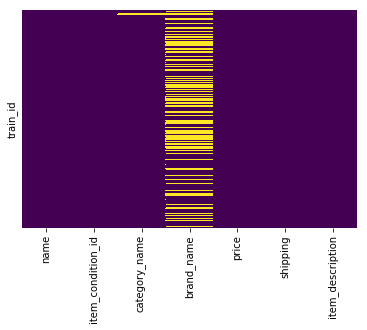

In [0]:
#heatmap koji prikazuje žutu liniju gdje imamo Nan vrijednosti
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [0]:
i = data.name.value_counts().size
print ('Number of distinct items names : ', i)

Number of distinct items names :  1225273


In [0]:
nb_cat = data.category_name.value_counts().size
print ('We have', nb_cat, 'different items categories.')

We have 1287 different items categories.


In [0]:
nb_brand = data.brand_name.value_counts().size
print ('We have', nb_brand, 'different items brands.')

We have 4809 different items brands.


In [0]:
#Imamo li NaN Vrijednosti?
data.isna().sum()

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

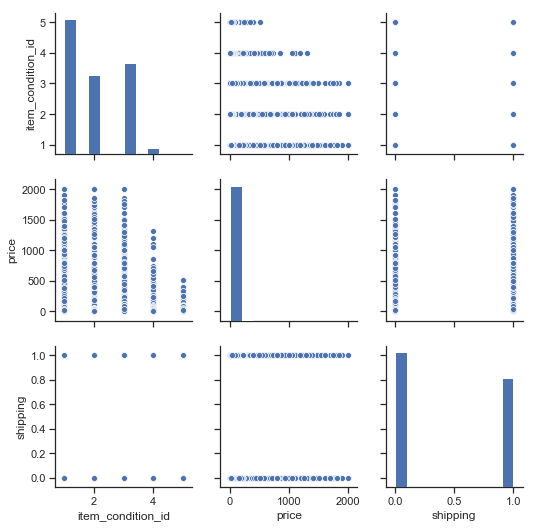

In [0]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data)
plt.show()

Prikaz mreže osi gdje je svaka varijabla povezana sa svakom.
Dijagonalni grafovi prikazuju univarijantnu distribuciju svake varijable, dok preostali prostali međusonu vezu između pojedinih varijabli.

In [0]:
#sns.catplot(x="category_name", y="price", kind="swarm", data=data)

### Analiza varijable *price*

In [0]:
data['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Cijena se nalazi u rasponu od 0 do 2009, sa prosječnom cijenom 26  i medianom 17 \$.

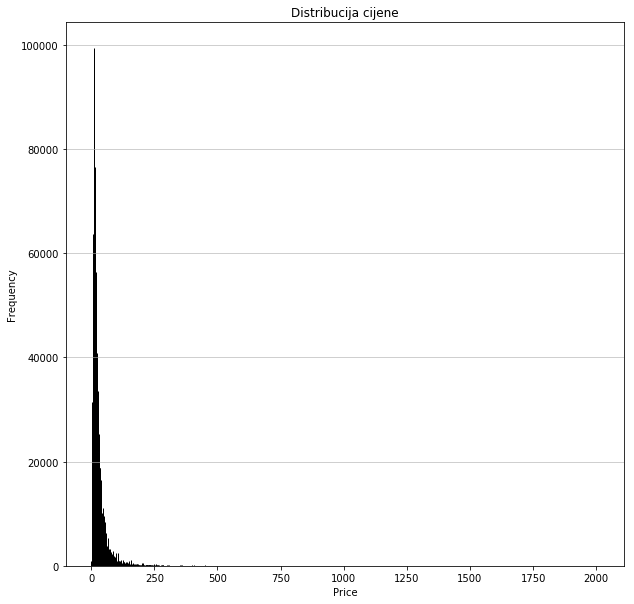

In [0]:
plt.figure(figsize=(10,10))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribucija cijene')
plt.hist(data['price'], color = 'blue', edgecolor = 'black',
    bins = 200)
plt.show()

Cijena prikazana ovom grafu ima težak desni rep, što će utjecati na na našu predikciju. S obzirom na *skewness* tj asimetriju podataka, median cijene je pouzdaniji od očekivanja.

Odrežimo graf tako da gledamo cijene manje od 250\$.

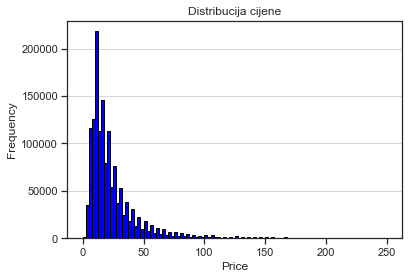

In [0]:
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribucija cijene')
plt.hist(data['price'], color = 'blue', edgecolor = 'black',
    bins = 100,range=[0,250])
plt.show()

Koliko ima proizvoda sa cijenom većom od 100$?

In [0]:
(data['price']>75).sum()

72541

In [0]:
72541/(len(data['price']))

0.04893037938396058

Imamo 4.89% proizvoda sa cijenom većom od $75.

Kako izgleda graf logaritmiranih cijena?

In [0]:
data['price_log']=np.log(data['price']+1)

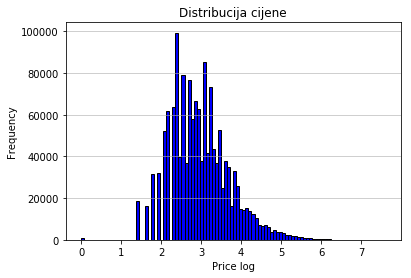

In [0]:
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Price log')
plt.ylabel('Frequency')
plt.title('Distribucija cijene')
plt.hist(data['price_log'], color = 'blue', edgecolor = 'black',
    bins = 100)
plt.show()

Logaritmiranjem cijene tranformiramo distribuciju tako da dobijemo model koji je balansiran, distribucija liči na normalnu. 

### Analiza varijable *item_condition_id*

Ovisi li cijena o *item_condition_id* varijabli?

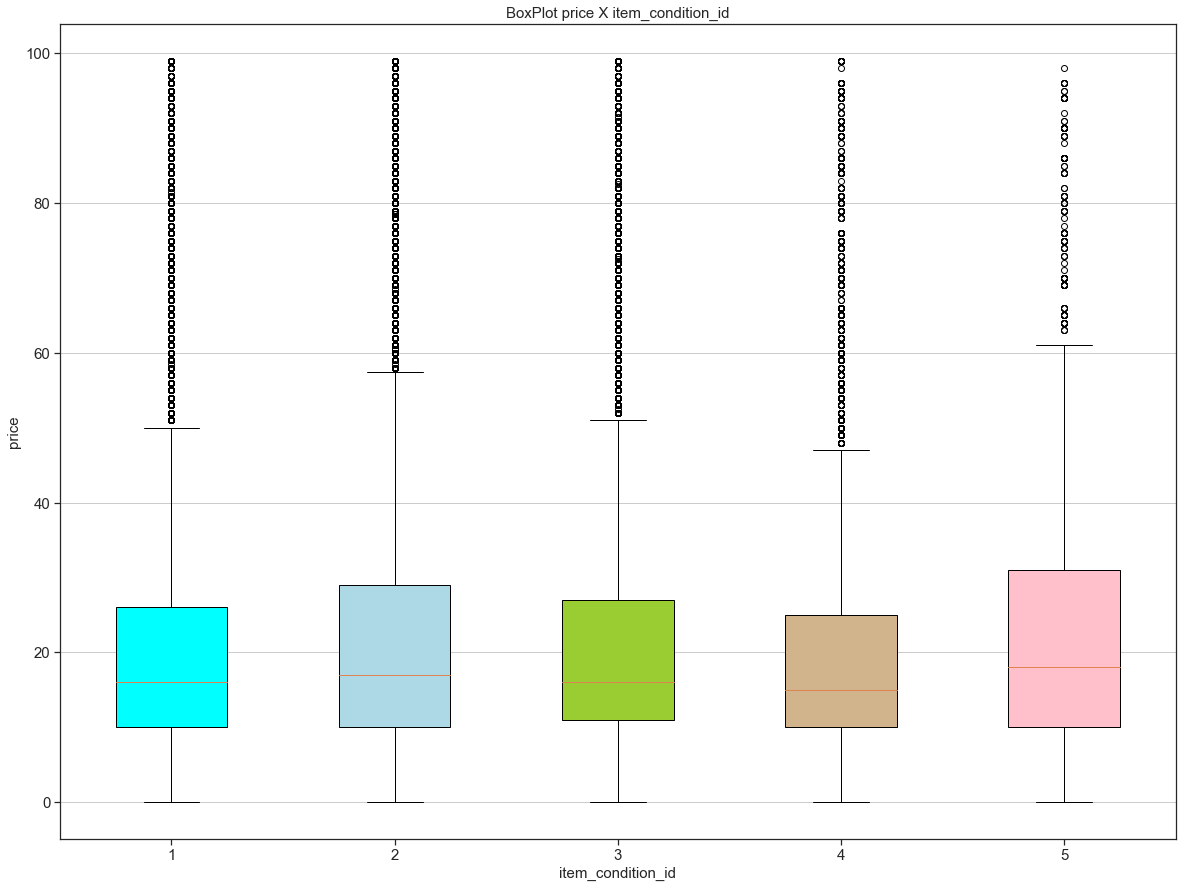

In [0]:
#Uzmimo cijene manje od 100$
df = data[data['price']<100]
my_plot = []
for i in data['item_condition_id'].unique():
    my_plot.append(df[df['item_condition_id']==i]['price'])

fig, axes = plt.subplots(figsize=(20, 15))
bp = axes.boxplot(my_plot,vert=True,patch_artist=True,labels=range(1,6)) 

colors = ['aqua', 'lightblue', 'yellowgreen', 'tan', 'pink']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

axes.yaxis.grid(True)

plt.title('BoxPlot price X item_condition_id', fontsize=15)
plt.xlabel('item_condition_id', fontsize=15)
plt.ylabel('price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

del df

Analizom ovog grafa naslućujemo da nema značajne razlike cijene po *item_condition_id* kategorijama.

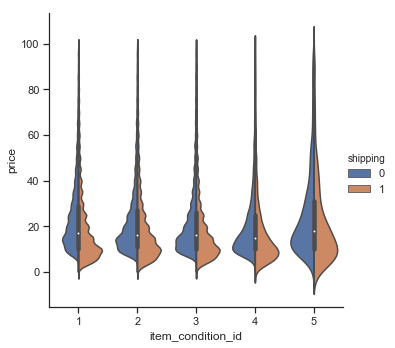

In [0]:
df = data[data['price']<100]
sns.catplot(x="item_condition_id", y="price", hue="shipping", kind="violin", split=True, data=df)

### Analiza varijable *category_name*

Text(0.5, 0, 'Number of product in the category')

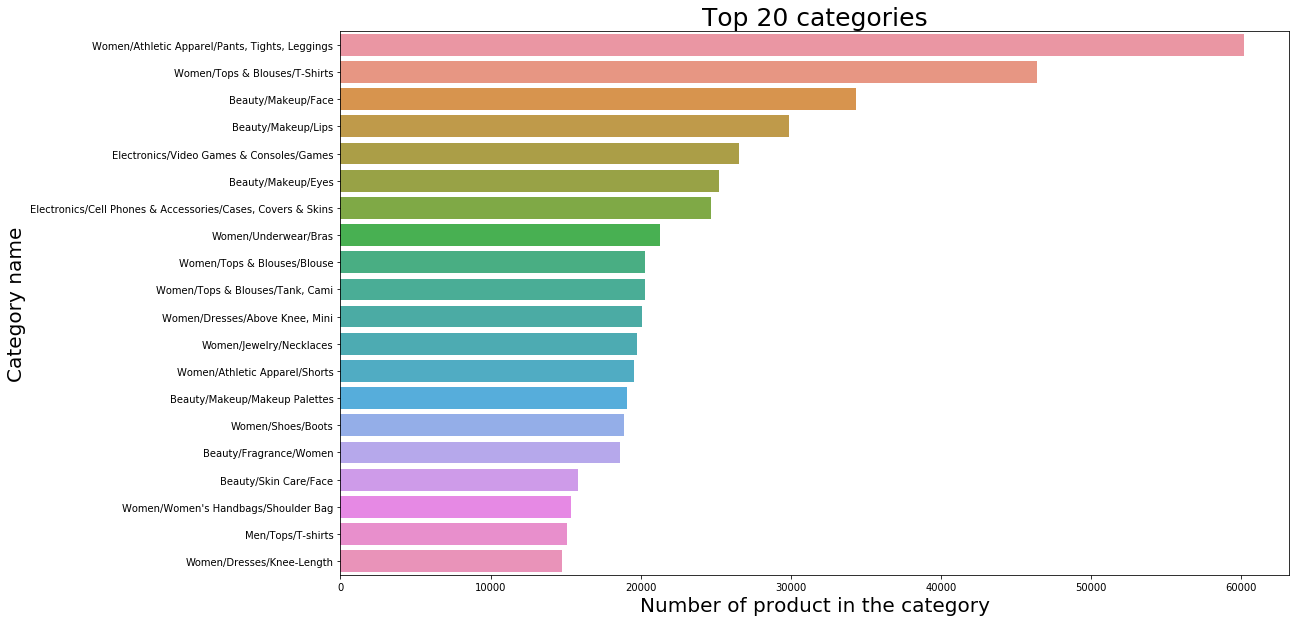

In [0]:
plt.figure(figsize=(17,10))
sns.countplot(y = data.category_name, order = data.category_name.value_counts().iloc[:20].index,  orient = 'v')
plt.title('Top 20 categories', fontsize = 25)
plt.ylabel('Category name', fontsize = 20)
plt.xlabel('Number of product in the category', fontsize = 20)

In [0]:
# Grupiranje po kategorijama
cat = pd.DataFrame(data.category_name.value_counts())
cat.reset_index(level = 0, inplace=True)
cat = cat.sort_values(by='category_name', ascending = False)
cat.columns =('category_name', 'size')
#cat #1287
#cat[cat['size']>3] #1112
#cat[cat['size']>10] #958
#cat[cat['size']>100] #603
cat[cat['size']>1000] #603

,category_name,size
0,"Women/Athletic Apparel/Pants, Tights, Leggings",60177
1,Women/Tops & Blouses/T-Shirts,46380
2,Beauty/Makeup/Face,34335
3,Beauty/Makeup/Lips,29910
4,Electronics/Video Games & Consoles/Games,26557
5,Beauty/Makeup/Eyes,25215
6,"Electronics/Cell Phones & Accessories/Cases, C...",24676
7,Women/Underwear/Bras,21274
8,Women/Tops & Blouses/Blouse,20284
9,"Women/Tops & Blouses/Tank, Cami",20284


Od ukupno 1287 kategorija, njih 958 ima više od 10 proizvoda, dok njih 603 ima više od 100 proizvoda.

Dodatno, postoji 238 kategorija koje imaju više od 1000 proizvoda.

Pogledajmo kakva je prosječna cijena po kategorijama.

In [0]:
group = data.groupby(data.category_name)
mean_price = group.price.mean()
mean_price = mean_price.to_frame()
mean_price.reset_index(level = 0, inplace=True)
mean_price

# Merging
cats = pd.merge(cat, mean_price, how='left', on = 'category_name')
cats=cats.sort_values(by='size',ascending=False)
cats.reset_index(drop=True, inplace=True)
cats

,category_name,size,price
0,"Women/Athletic Apparel/Pants, Tights, Leggings",60177,34.392733
1,Women/Tops & Blouses/T-Shirts,46380,19.386125
2,Beauty/Makeup/Face,34335,18.470890
3,Beauty/Makeup/Lips,29910,18.520846
4,Electronics/Video Games & Consoles/Games,26557,24.119667
5,Beauty/Makeup/Eyes,25215,14.621931
6,"Electronics/Cell Phones & Accessories/Cases, C...",24676,13.174360
7,Women/Underwear/Bras,21274,18.636364
8,Women/Tops & Blouses/Blouse,20284,15.660102
9,"Women/Tops & Blouses/Tank, Cami",20284,14.411655


In [0]:
manje_od_20=cats[cats["size"]<20]
manje_od_20

,category_name,size,price
865,Vintage & Collectibles/Book/Instructional,19,9.842105
866,Vintage & Collectibles/Serving/Teapot,19,18.526316
867,Home/Seasonal Décor/Birthday,19,13.210526
868,Home/Furniture/Other Furniture,19,27.736842
869,Vintage & Collectibles/Home Decor/Basket,19,37.315789
870,Home/Bedding/Inflatable Beds,19,37.684211
871,Other/Automotive/Performance Parts & Accessories,19,31.000000
872,Home/Home Appliances/Refrigerators,19,34.684211
873,Women/Skirts/Peasant,18,12.444444
874,Vintage & Collectibles/Accessories/Brooch,18,11.555556


Text(0.5, 0, 'Mean price')

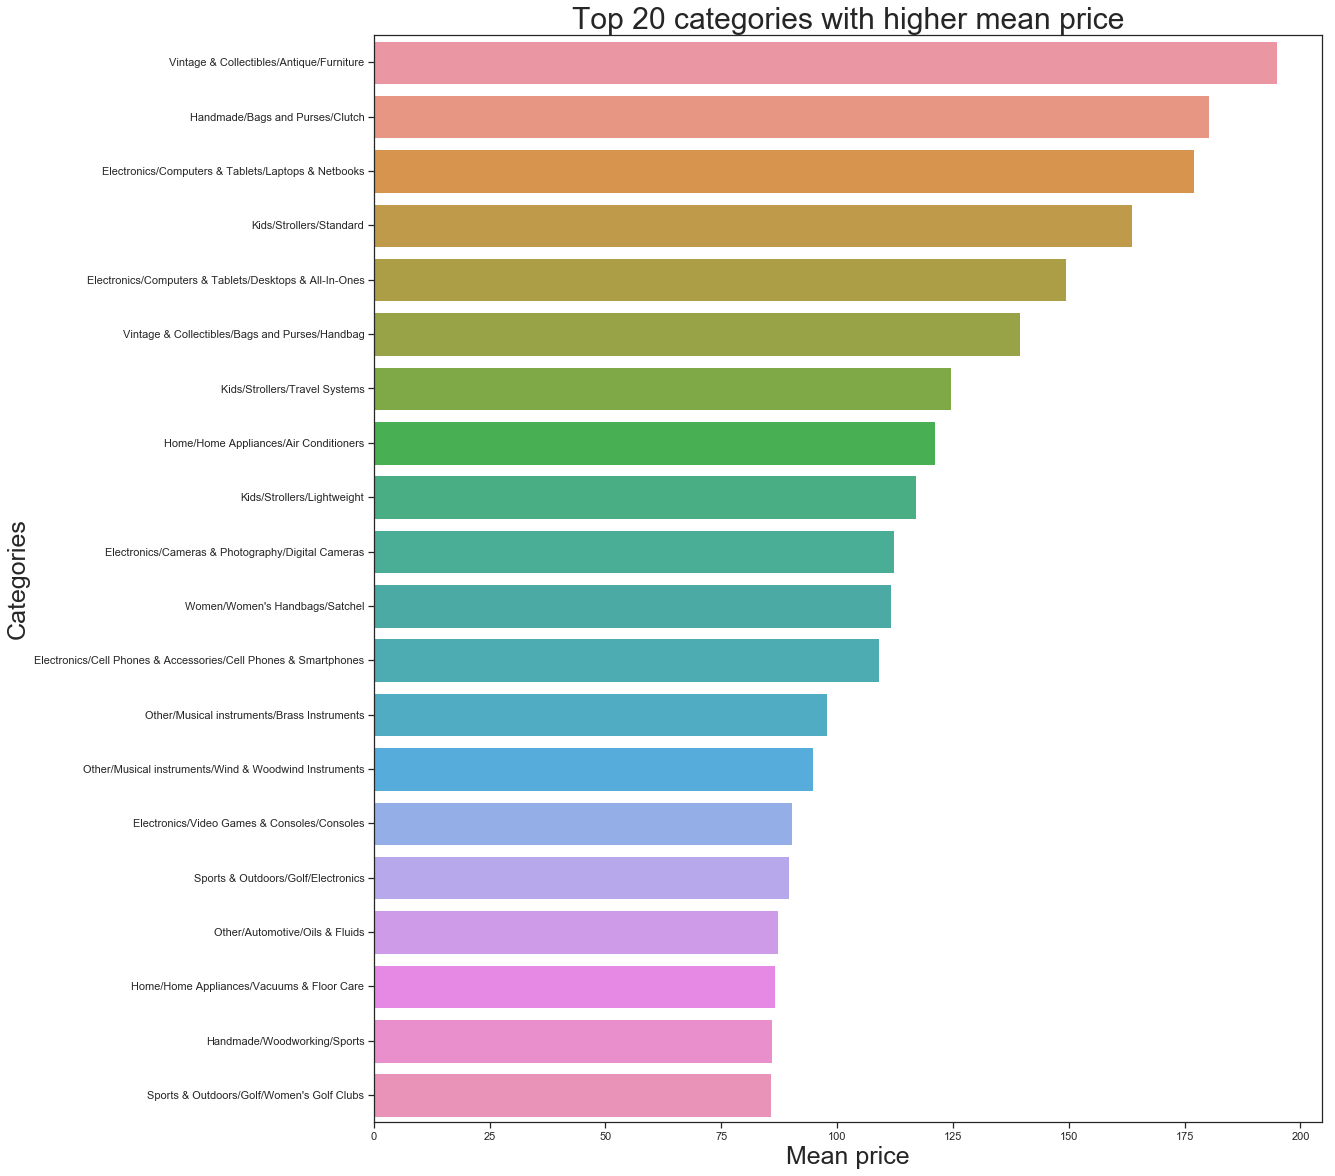

In [0]:
mean_price = mean_price.sort_values(by='price', ascending = False).head(20)
mean_price.reset_index(level = 0, inplace=True)

plt.figure(figsize=(17,20))
sns.barplot(x = 'price', y = 'category_name', data = mean_price, orient = 'h')
plt.title('Top 20 categories with higher mean price', fontsize = 30)
plt.ylabel('Categories', fontsize = 25)
plt.xlabel('Mean price', fontsize = 25)

Text(0.5, 0, 'Mean price of each category')

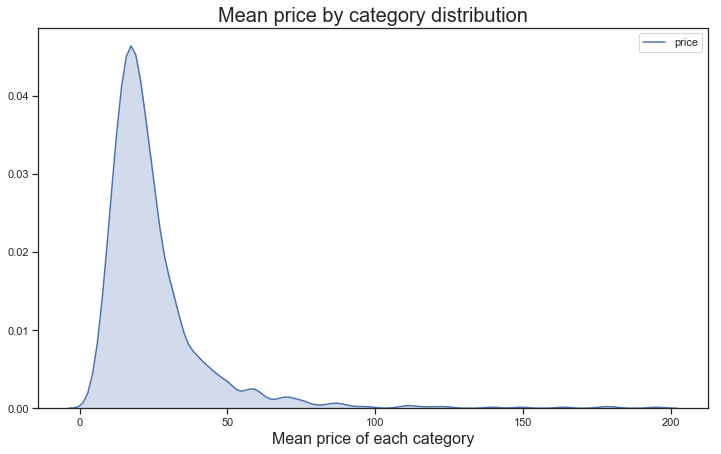

In [0]:
mean_price_2 = pd.DataFrame(group.price.mean())
mean_price_2.reset_index(level = 0, inplace=True)

plt.figure(figsize =(12,7))
sns.kdeplot(mean_price_2.price, shade = True)
plt.title('Mean price by category distribution', fontsize = 20)
plt.xlabel('Mean price of each category', fontsize = 16)

### Analiza varijable *brand_name*

S obzirom da prilično velik broj nedostajućih vrijednosti za stupac *brand_name*, nadopuniti ćemo neke vrijednosti iz stupca *name*, jer se tamo, bar koliko se može primijetiti iz ispisanih vrijednosti, često pojavljuje i ime marke.

In [0]:
brandovi2=data['brand_name']
brandovi1=test['brand_name']

In [0]:
brandovi1.nunique() #broj jedinstvenih imena brendova

3900

In [0]:
svi_brandovi=set(brandovi1.values)
for y in brandovi2:
    svi_brandovi.add(y)
svi_brandovi = {x for x in svi_brandovi if pd.notna(x)}
len(svi_brandovi)
svi_brandovi-={'M', 'K', 'X'}
# izbacujem ove s jednim slovom jer mi njih prečesto ubacuje u nedostajuće brandove, a nisam sigurna treba li

In [0]:
missing_brands = data.brand_name.isnull().sum()
missing_brands_test = test.brand_name.isnull().sum()
missing_brands, missing_brands_test

(632682, 295525)

Prolazimo kroz training set i tražimo podudaranja između imena i skupa svih brandova

In [0]:
def trazilica(objekt):
    brand=objekt[0]
    ime=objekt[1]
    if pd.isna(brand):
        for i in svi_brandovi:
            if i in ime:
                return i
    return brand
data['brand_name']=data[['brand_name', 'name']].apply(trazilica, axis=1)
test['brand_name']=test[['brand_name', 'name']].apply(trazilica, axis=1)

In [0]:
missing_brands = data.brand_name.isnull().sum()
missing_brands_test = test.brand_name.isnull().sum()
missing_brands, missing_brands_test

(423953, 198290)

Uspjeli smo popuniti 208729 *missing branda*.

Text(0.5, 0, 'Number of product')

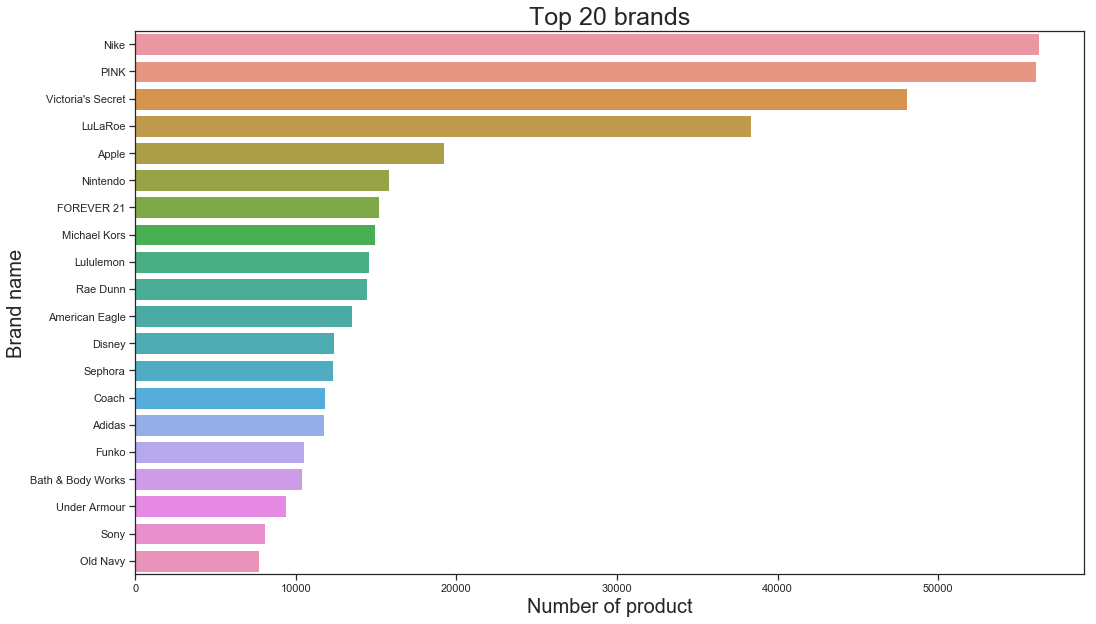

In [0]:
plt.figure(figsize=(17,10))
sns.countplot(y = data.brand_name, order = data.brand_name.value_counts().iloc[:20].index, orient = 'v')
plt.title('Top 20 brands', fontsize = 25)
plt.ylabel('Brand name', fontsize = 20)
plt.xlabel('Number of product', fontsize = 20)

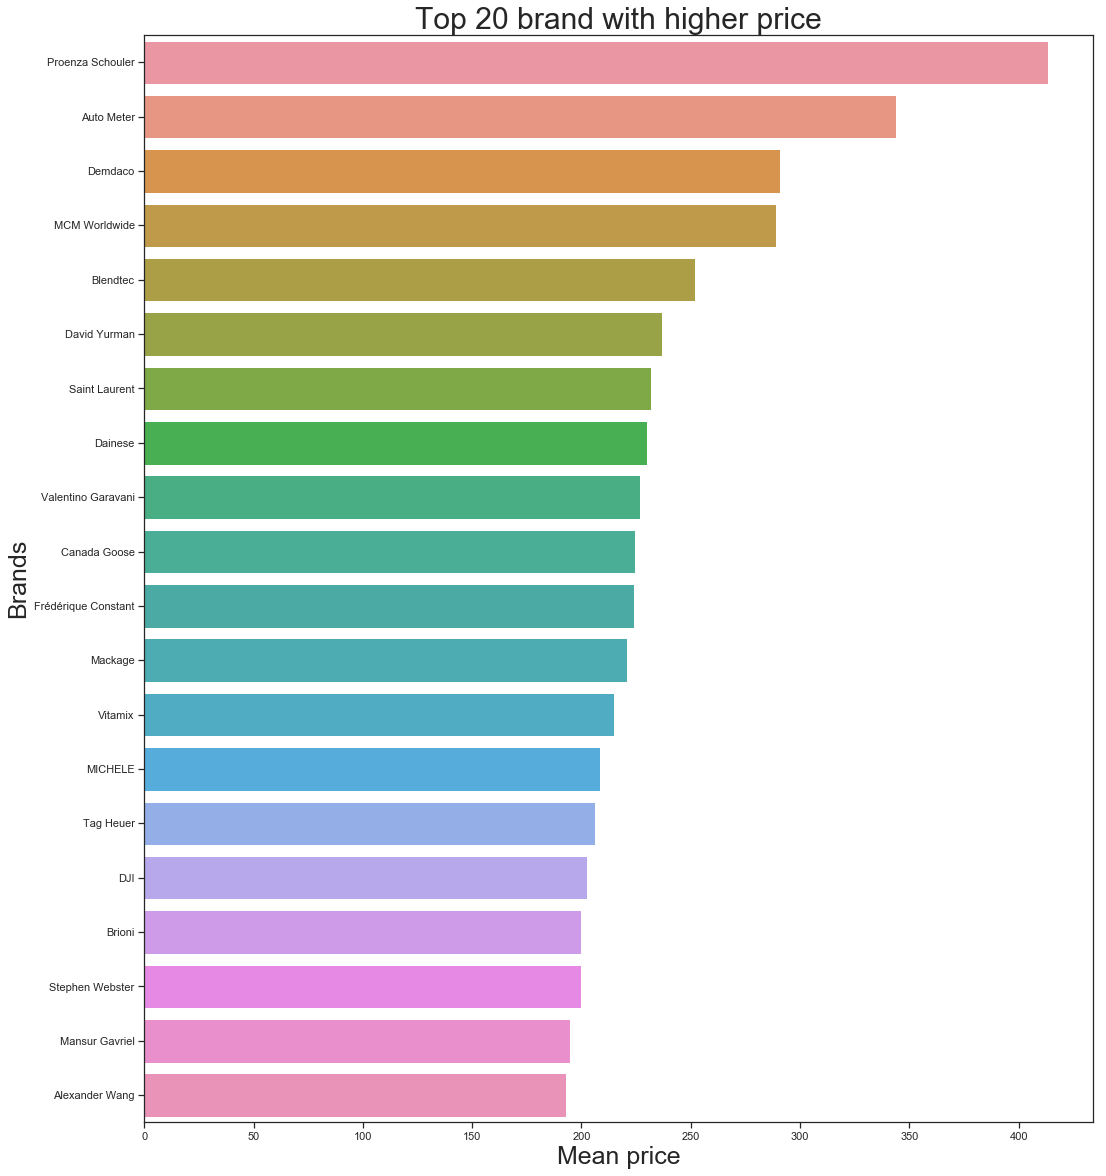

Nike                           5.313807e-02
PINK                           5.301148e-02
Victoria's Secret              4.537768e-02
LuLaRoe                        3.623054e-02
Apple                          1.819132e-02
Nintendo                       1.495775e-02
FOREVER 21                     1.435222e-02
Michael Kors                   1.410094e-02
Lululemon                      1.375236e-02
Rae Dunn                       1.363050e-02
American Eagle                 1.275480e-02
Disney                         1.172890e-02
Sephora                        1.162876e-02
Coach                          1.118572e-02
Adidas                         1.113282e-02
Funko                          9.957660e-03
Bath & Body Works              9.811238e-03
Under Armour                   8.882637e-03
Sony                           7.637576e-03
Old Navy                       7.283328e-03
Hollister                      6.826113e-03
Carter's                       6.082665e-03
Urban Decay                    6

In [0]:
# Display Top 20 Expensive Brands By Mean Price

mean_price1 = data.groupby('brand_name', axis=0).mean()
df= pd.DataFrame(mean_price1.sort_values('price', ascending = False)['price'][0:20].reset_index())

plt.figure(figsize=(17,20))
sns.barplot(x = 'price', y = 'brand_name', data = df, orient = 'h')
plt.title('Top 20 brand with higher price', fontsize = 30)
plt.ylabel('Brands', fontsize = 25)
plt.xlabel('Mean price', fontsize = 25)
plt.show()


# Displayd frequency ratio of brand names
data['brand_name'].value_counts(1)

In [0]:
#data['brand_name'].isna().sum() #632682
#data['has_brend'] = 1
#data.loc[~data['brand_name'].isna()] = 0
#data.head()

#datan=data.loc[data.brand_name.isna()==False]
#datan.reset_index(drop=True, inplace=True)
#datan

In [0]:
#bez NaN
#plt.figure(figsize=(17,10))
#sns.countplot(y = datan.brand_name, order = datan.brand_name.value_counts().iloc[:20].index, orient = 'v')
#plt.title('Top 20 brands', fontsize = 25)
#plt.ylabel('Brand name', fontsize = 20)
#plt.xlabel('Number of product', fontsize = 20)

In [0]:
data1 = data.loc[data.price>200]
data1.name = data1.name.str.upper()

wc = WordCloud(background_color="white", max_words=5000, stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in data1.name.values))

plt.figure(figsize=(20,12))
plt.title('What are the most expensive items', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

NameError: name 'WordCloud' is not defined

In [0]:
data1 = data.loc[data.price>200]
data1.brand_name = data1.brand_name.str.upper()

wc = WordCloud(background_color="white", max_words=5000, stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in data1.brand_name.values))

plt.figure(figsize=(20,12))
plt.title('What are the most expensive brands', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

NameError: name 'WordCloud' is not defined

Primjetili smo da se varijabla *category_name* sastoji od 3 levela. Razdvajanjem dobivamo 3 nova *featuresa* tako da svaki ima vrijednost jednog levela kategorije.

In [0]:
data["subcat1"] = data.category_name.str.extract("([^/]+)/[^/]+/[^/]+", expand=False)
data["subcat2"] = data.category_name.str.extract("[^/]+/([^/]+)/[^/]+", expand=False)
data["subcat3"] = data.category_name.str.extract("[^/]+/[^/]+/([^/]+)", expand=False)

In [0]:
# excluding NA group
print("Number of Main Categories = " + str(len(pd.unique(data["subcat1"]))-1))
print("Number of Sub Category 1 = " + str(len(pd.unique(data["subcat2"]))-1))
print("Number of Sub Category 2 = " + str(len(pd.unique(data["subcat3"]))-1))

Number of Main Categories = 10
Number of Sub Category 1 = 113
Number of Sub Category 2 = 870


In [0]:
list(pd.unique(data["subcat1"]))

['Men',
 'Electronics',
 'Women',
 'Home',
 'Sports & Outdoors',
 'Vintage & Collectibles',
 'Beauty',
 'Other',
 'Kids',
 nan,
 'Handmade']

In [0]:
list(pd.unique(data["subcat2"]))

['Tops',
 'Computers & Tablets',
 'Tops & Blouses',
 'Home Décor',
 'Jewelry',
 'Other',
 'Swimwear',
 'Apparel',
 'Collectibles',
 'Makeup',
 'Fragrance',
 'Dresses',
 'Office supplies',
 'Shoes',
 'Gear',
 'Athletic Apparel',
 'Cell Phones & Accessories',
 'Jeans',
 'Underwear',
 'Skin Care',
 'Toys',
 "Women's Handbags",
 'Video Games & Consoles',
 'Coats & Jackets',
 'Pants',
 'Girls (4+)',
 'Antique',
 'Kitchen & Dining',
 'Sweaters',
 'Boys 0-24 Mos',
 'Girls 0-24 Mos',
 'Maternity',
 'Bedding',
 'Exercise',
 'Trading Cards',
 'Boys (4+)',
 'Storage & Organization',
 'Fan Shop',
 'Girls 2T-5T',
 "Men's Accessories",
 'Boys 2T-5T',
 "Women's Accessories",
 'Daily & Travel items',
 nan,
 'Skirts',
 'Hair Care',
 'Pet Supplies',
 'Book',
 'Tools & Accessories',
 'Team Sports',
 'Home Appliances',
 'Accessories',
 'Bags and Purses',
 'Sweats & Hoodies',
 'Shorts',
 'TV, Audio & Surveillance',
 'Outdoors',
 'Bath & Body',
 'Car Seats & Accessories',
 'Toy',
 'Art',
 'Seasonal Décor',


In [0]:
list(pd.unique(data["subcat3"]))

['T-shirts',
 'Components & Parts',
 'Blouse',
 'Home Décor Accents',
 'Necklaces',
 'Other',
 'Two-Piece',
 'Girls',
 'Doll',
 'Face',
 'Women',
 'Above Knee, Mini',
 'School Supplies',
 'Boots',
 'Makeup Sets',
 'Eyes',
 'Backpacks & Carriers',
 'Makeup Palettes',
 'Tank, Cami',
 'Sports Bras',
 'Cell Phones & Smartphones',
 'Chargers & Cradles',
 'T-Shirts',
 'Athletic',
 'Cases, Covers & Skins',
 'Pants, Tights, Leggings',
 'One-Piece',
 'Boot Cut',
 'Bras',
 'Stuffed Animals & Plush',
 'Totes & Shoppers',
 'Shirts & Tops',
 'Consoles',
 'Glass',
 'Vest',
 'Arts & Crafts',
 'Capris, Cropped',
 'Messenger & Crossbody',
 'Shoes',
 'Collectibles',
 'Coffee & Tea Accessories',
 'Brooch',
 'Headsets',
 'Rings',
 'Shorts',
 'Fleece Jacket',
 'Dolls & Accessories',
 'Crewneck',
 'Jackets',
 'Home Fragrance',
 'Accessories',
 'Tops & Blouses',
 'Sheets & Pillowcases',
 'Fitness technology',
 'Dress Up & Pretend Play',
 'Animation',
 'Jewelry Boxes & Organizers',
 'Games',
 'NCAA',
 'Electr

Distribucija cijene u prvom levelu kategorije.

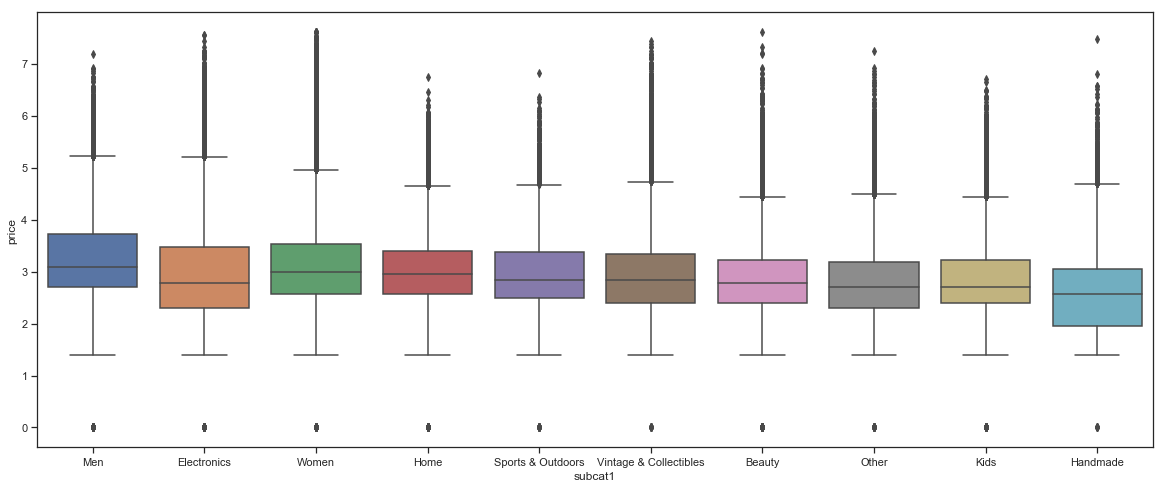

In [0]:
plt.figure(figsize = (20, 8))
sns.boxplot(x = data.subcat1, y = np.log(data.price+1))

In [0]:
data.groupby('subcat1')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
subcat1,,,,,,,,
Beauty,207828.0,19.671536,21.360135,0.0,10.0,15.0,24.0,2000.0
Electronics,122690.0,35.173922,65.419784,0.0,9.0,15.0,31.0,1909.0
Handmade,30842.0,18.156572,27.758289,0.0,6.0,12.0,20.0,1750.0
Home,67871.0,24.536599,24.417061,0.0,12.0,18.0,29.0,848.0
Kids,171689.0,20.642315,22.730876,0.0,10.0,14.0,24.0,809.0
Men,93680.0,34.708614,41.240057,0.0,14.0,21.0,40.0,1309.0
Other,45351.0,20.809817,29.847758,0.0,9.0,14.0,23.0,1400.0
Sports & Outdoors,25342.0,25.532219,29.302234,0.0,11.0,16.0,28.0,915.0
Vintage & Collectibles,46530.0,27.339426,53.507495,0.0,10.0,16.0,27.0,1709.0


In [0]:
data['subcat1'].value_counts(1)

Women                     0.450062
Beauty                    0.140785
Kids                      0.116304
Electronics               0.083112
Men                       0.063460
Home                      0.045977
Vintage & Collectibles    0.031520
Other                     0.030721
Handmade                  0.020893
Sports & Outdoors         0.017167
Name: subcat1, dtype: float64

*Women* i *Beauty* su najzastupljenije glavne kategorije (ukupno 56%).
*Electronics* kategorija ima najveću standarnu devijaciju

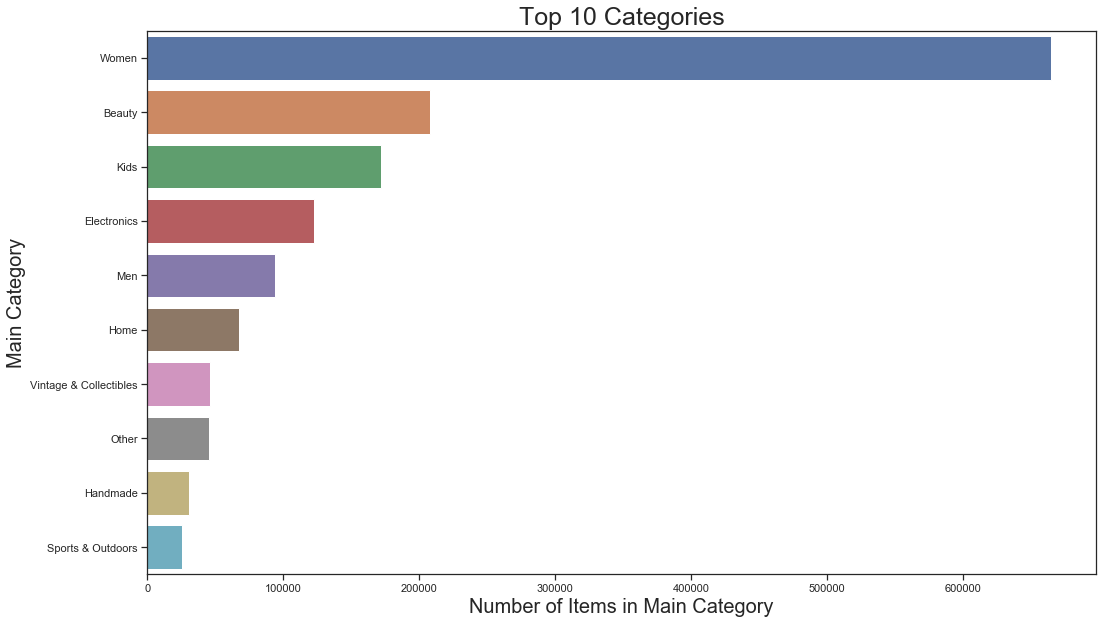

In [0]:
plt.figure(figsize=(17,10))
sns.countplot(y = data['subcat1'], order = data['subcat1'].value_counts().index, orient = 'v')
plt.title('Top 10 Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Number of Items in Main Category', fontsize = 20)
plt.show()

In [0]:
# Create a "no_brand" column 
data['no_brand'] = data['brand_name'].isnull()

f, ax = plt.subplots(figsize=(17, 10))
sns.countplot(y='subcat1', hue='no_brand', data=data)
plt.title('Category Distribution With/Without Brand')
plt.show()

Distribucija cijene u drugom i trećem levelu kategorije.

In [0]:
sub1 = data.groupby(["subcat2"], as_index = True).median().price.sort_values(ascending = False)
sub2 = data.groupby(["subcat3"], as_index = True).median().price.sort_values(ascending = False)

f, ax = plt.subplots(1,2,figsize=(15,5))
sns.distplot(sub1, ax=ax[0])
ax[0].set_title("Sub category 1")
sns.distplot(sub2, ax=ax[1])
ax[1].set_title("Sub category 2")

Još malo analize cijene...

In [0]:
data.price.describe()

In [0]:
# Mozemo li iskoristiti neka svojstva kvantila cijene kao nove featurese?
bins = [0, 10, 17, 29, 2001]
labels = ['q1','q2','q3','q4']
data['price_bin'] = pd.cut(data['price'], bins=bins, labels=labels)
data.groupby('price_bin')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_bin,,,,,,,,
q1,375615.0,7.715192,2.077888,3.0,6.0,8.0,10.0,10.0
q2,378177.0,13.842940,1.794584,10.5,12.0,14.0,15.0,17.0
q3,359743.0,22.555694,3.337832,17.5,20.0,22.0,25.0,29.0
q4,368123.0,63.527701,63.508250,29.5,35.0,45.0,66.0,2000.0


In [0]:
CAT_MIN = 5
STD_SIGMAS = 2
cats_stats = data.groupby(['category_name', 'brand_name', 'shipping']).agg({'category_name': len,
                                               'price_log': [np.median, np.mean, np.std]})
cats_stats.columns = ['price_log_median', 'price_log_mean', 'price_log_std','count']
#Removing categories without a minimum threshold of samples
cats_stats.drop(cats_stats[cats_stats['count'] < CAT_MIN].index, inplace=True)
cats_stats['price_log_std'] = cats_stats['price_log_std'].fillna(0)
cats_stats['price_log_conf_variance'] = cats_stats['price_log_std'] / cats_stats['price_log_mean']
cats_stats['count_log'] = np.log1p(cats_stats['count'])
cats_stats['min_expected_log_price'] = (cats_stats['price_log_mean'] - cats_stats['price_log_std']*STD_SIGMAS).clip(lower=1.0)
cats_stats['max_expected_log_price'] = (cats_stats['price_log_mean'] + cats_stats['price_log_std']*STD_SIGMAS)


C:\Users\Ivan Emanuel Pavlov\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log1p
  # Remove the CWD from sys.path while we load stuff.


### Analiza varijable *shipping*

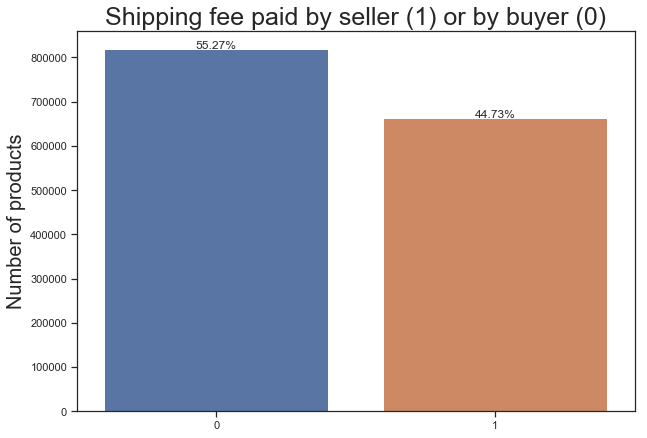

In [0]:
total = float(len(data.shipping))

plt.figure(figsize=(10,7))
ax = sns.countplot(data.shipping)
plt.title('Shipping fee paid by seller (1) or by buyer (0)', fontsize = 25)
plt.ylabel('Number of products', fontsize = 20)
plt.xlabel('')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:.2f}%'.format((height/total)*100),
            ha="center") 

Text(0, 0.5, 'Price without outliers')

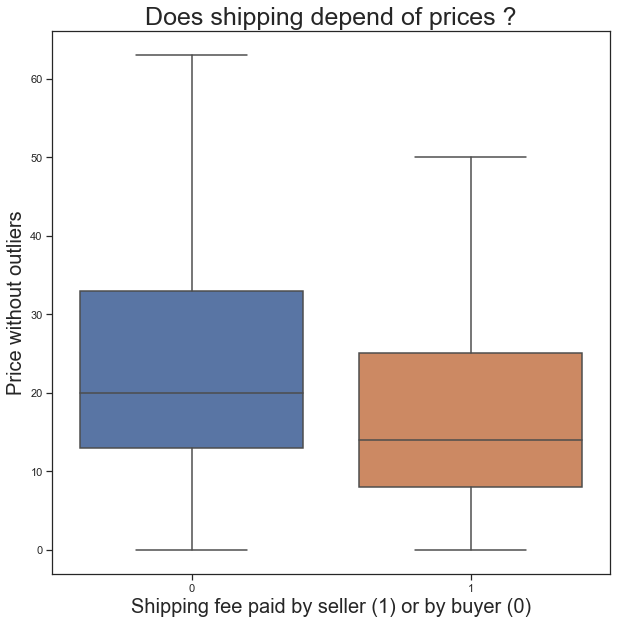

In [0]:
plt.figure(figsize=(10,10))
sns.boxplot(x=data.shipping, y = data.price, showfliers=False, orient = 'v')
plt.title('Does shipping depend of prices ?', fontsize = 25)
plt.xlabel('Shipping fee paid by seller (1) or by buyer (0)', fontsize = 20)
plt.ylabel('Price without outliers', fontsize = 20)

### Analiza varijable *item_description*

In [0]:
data['has_description'] = 1
data.loc[data['item_description']=='No description yet', 'has_description'] = 0
data.head()
data.loc[data.has_description ==1].head() #1400046

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,price_log,subcat1,subcat2,subcat3,price_bin,has_description
train_id,,,,,,,,,,,,,
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts,q4,1
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse,q1,1
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents,q4,1
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces,q4,1
5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma...",4.094345,Women,Other,Other,q4,1


In [0]:
data.loc[data.has_description ==0].shape #82489

(82489, 13)

Imamo 82489 'No description yet' vrijednosti varijable *item_description*.

Ima li razlike u distribuciji cijene kada imamo ili nemamo opis?

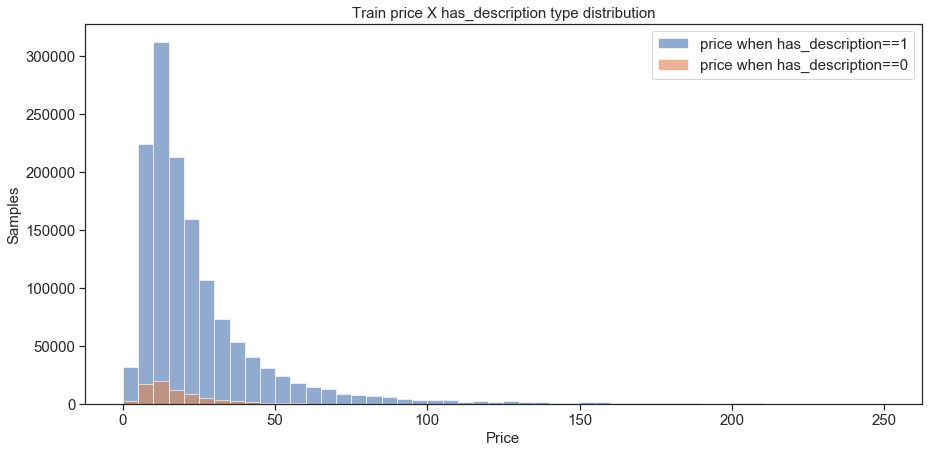

In [0]:
plt.figure(figsize=(15, 7))
bins=50
plt.hist(data[data['has_description']==1]['price'], bins, range=[0,250],
         alpha=0.6, label='price when has_description==1')
plt.hist(data[data['has_description']==0]['price'], bins, range=[0,250],
         alpha=0.6, label='price when has_description==0')
plt.title('Train price X has_description type distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Analizom ovog histograma vidimo da je distribucija cijene kada nema opisa vrlo slična distribuciji kada imamo opis, ako uzmemo u obzir da je veličina uzoraka u histogramima jako različita. Normalizirani histogram nam može bolje pokazati sličnost.

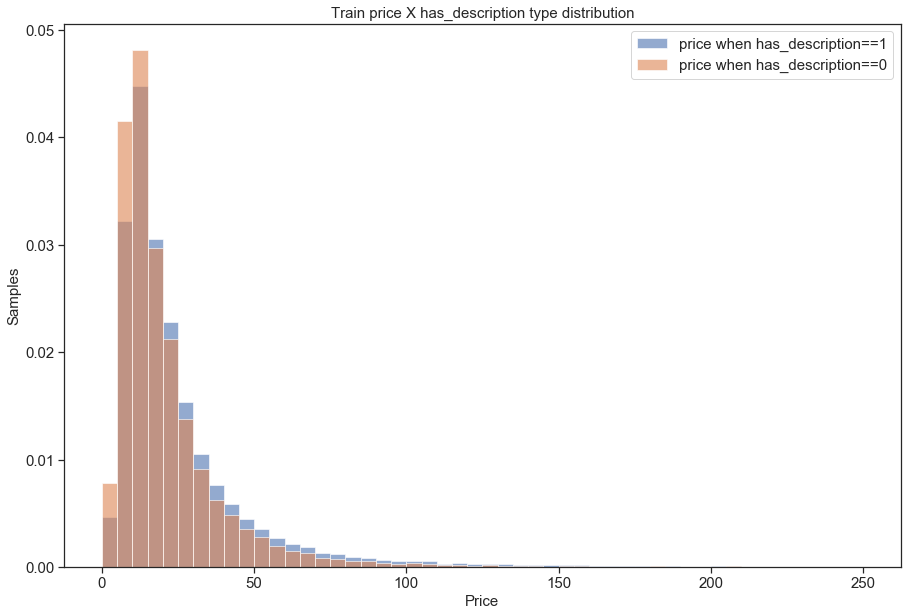

In [0]:
plt.figure(figsize=(15, 10))
bins=50
plt.hist(data[data['has_description']==1]['price'], bins, density=True, range=[0,250],
         alpha=0.6, label='price when has_description==1')
plt.hist(data[data['has_description']==0]['price'], bins, density=True, range=[0,250],
         alpha=0.6, label='price when has_description==0')
plt.title('Train price X has_description type distribution', fontsize=15)
plt.xlabel('Price', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [0]:
df=data
df = df[~df['item_description'].isnull()]
df = df[df['item_description']!='No description yet']

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText

df['item_description'] = preprocess(df['item_description'])

df.insert(loc=len(df.columns), column='polarity', value=0)
df.insert(loc=len(df.columns), column='word_count', value=0)

In [0]:
df['polarity'] = df['item_description'].map(lambda text: TextBlob(text).sentiment.polarity)
df['description_length'] = df['item_description'].astype(str).apply(len)
df['word_count'] = df['item_description'].apply(lambda x: len(str(x).split()))

NameError: name 'TextBlob' is not defined

In [0]:
print('Pet nasumičnih opisa najpozitivnijeg tona: \n')
cl = df.loc[df.polarity == 1, ['item_description']].sample(5).values
for c in cl:
    print(c[0])

Pet nasumičnih opisa najpozitivnijeg tona: 



ValueError: 'a' must be greater than 0 unless no samples are taken

In [0]:
print('Pet nasumičnih opisa neutralnog tona: \n')
c2 = df.loc[df.polarity == 0, ['item_description']].sample(5).values
for c in c2:
    print(c[0])

Pet nasumičnih opisa neutralnog tona: 

Size: M
these are handmade stickers shown will be stickers given. water resistant shipped in envelope with stamp great for binders, laptops, notebooks, etc
Texas instruments TI-86 graphing calculator. Great condition. Has the book and the orginal package. Paid [rm]. Willing to negotiate, but remember I'm paying for shipping and it's a much better calculator than the TI-84
Charcoal Ralph Lauren Polo Hat. Worn twice. Bought from Macy's.
Model: DXRC01A12 Part Number: DXRC01A12 Associated Number: DX-RC01A-12 This remote control controls units : TV Battery Required : 2 AAA Originally supplied with models: dx15e220a12 - Dx19e220a12 - Dx24l200a12 - Dx24l230a12 - Dx26l100a13 - Dx32l100a13 - Dx32l200a12 - Dx32l220a12 - Dx32l230a12 - Dx32l230a12a - Dx37l200a12 - Dx37l200a12a - Dx40l261a12 - Dx42e250a12 - Dx46l260a12 - Dx46l261a12 - Dx46l262a12 - Dx46l262a12a - Dx46l262a12b - Dx46l262a12c


In [0]:
print('Pet nasumičnih opisa negativnog tona: \n')
c3 = df.loc[df.polarity == -1, ['item_description']].sample(5).values
for c in c3:
    print(c[0])

Pet nasumičnih opisa negativnog tona: 



ValueError: 'a' must be greater than 0 unless no samples are taken

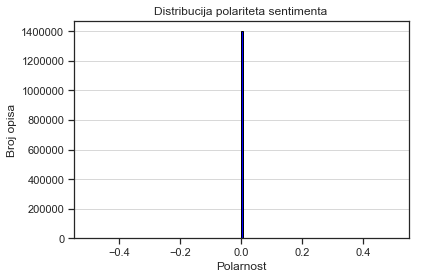

In [0]:
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Polarnost')
plt.ylabel('Broj opisa')
plt.title('Distribucija polariteta sentimenta')
plt.hist(df['polarity'], color = 'blue', edgecolor = 'black',
    bins = 200)
plt.show()

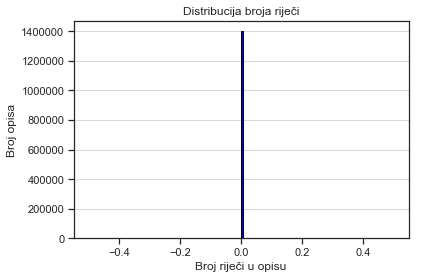

In [0]:
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Broj riječi u opisu')
plt.ylabel('Broj opisa')
plt.title('Distribucija broja riječi')
plt.hist(df['word_count'], color = 'blue', edgecolor = 'black',
    bins = 200)
plt.show()

In [0]:
df['polarity'].corr(df['price'])

nan

In [0]:
df['word_count'].corr(df['price'])

nan

Tražimo najčešće korištene riječi u opisima

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['item_description'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['item_description' , 'count'])

In [0]:
df2.plot.barh(x='item_description', y='count', rot=0)

In [0]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['item_description'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['item_description' , 'count'])

In [0]:
df3.plot.barh(x='item_description', y='count', rot=0)

## Data prepare

In [0]:
# handle_missing_values - Basic data imputation of missing values
def handle_missing_values(df):
    df['category_name'].fillna(value='missing', inplace=True)
    df['brand_name'].fillna(value='None', inplace=True)
    df['item_description'].fillna(value='None', inplace=True)

In [0]:
# to_categorical - Converts Categorical Features 
def to_categorical(df):
    df['brand_name'] = df['brand_name'].astype('category')
    df['category_name'] = df['category_name'].astype('category')
    df['item_condition_id'] = df['item_condition_id'].astype('category')

In [0]:
#data.drop(columns=['category_name'],inplace=True)
#data.head()

In [0]:
data2=data.sample(frac=1)

In [0]:
data_test=data2[0:150000]
data_train=data2[150000:]

In [0]:
#data_train.head()

In [0]:
data_train_labels=data_train["price"]

In [0]:
data_train_labels

train_id
340529      59.0
1344366     13.0
1475078     59.0
118254      30.0
1242879     22.0
278929       6.0
1173178     26.0
1109        11.0
638758      10.0
385855      40.0
912405      29.0
661137      49.0
191587       5.0
420124     178.0
545417      71.0
1374706      9.0
1186073     63.0
494450      11.0
424320      36.0
636525      11.0
1157546     47.0
629253      24.0
509413      65.0
1443205     25.0
1405445     24.0
233128     105.0
95134       29.0
280558       5.0
390492      45.0
616537      35.0
           ...  
590850       8.0
267013      30.0
1284073     12.0
896579      14.0
1216019      5.0
874861      18.0
1425414     55.0
1369813     17.0
854839     270.0
1220998     24.0
445606      19.0
622509      14.0
1311989     21.0
760921       8.0
476930      50.0
11595       31.0
143288      25.0
513730       7.0
211623       4.0
232240       9.0
950600      35.0
122263      79.0
1452372     13.0
504982      22.0
199585      51.0
261161      40.0
569197      14.0
35528

In [0]:
#from gensim import corpora



#Modeliranje

## Preprocesiranje



### missing

In [0]:
import spacy


In [0]:
from sklearn import preprocessing


In [0]:
x=data.drop("price",axis=1)
y=data["price"]



In [0]:
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)


In [11]:
handle_missing(x)

,name,item_condition_id,category_name,brand_name,shipping,item_description
train_id,,,,,,
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,0,Complete with certificate of authenticity
5,Bundled items requested for Ruie,3,Women/Other/Other,missing,0,"Banana republic bottoms, Candies skirt with ma..."
6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,0,Size small but straps slightly shortened to fi...
7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,1,You get three pairs of Sophie cheer shorts siz...
8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,0,Girls Size small Plus green. Three shorts total.


In [12]:
handle_missing(test)

,name,item_condition_id,category_name,brand_name,shipping,item_description
test_id,,,,,,
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,missing,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,missing,1,Rediscovering life after the loss of a loved o...
5,iPhone 6 Plus or 6s Plus Vodka pink case,1,"Electronics/Cell Phones & Accessories/Cases, C...",missing,1,One Absolut Vodka in Pink for iPhone 6 Plus an...
6,Vintage Cameo Pendant & Brooch Pin,3,Women/Jewelry/Necklaces,Vintage,1,Two vintage Cameo pieces. 1. Silver metal Lock...
7,Rose Gold Stainless Steel Quartz Watch,1,Women/Women's Accessories/Watches,missing,1,Brand new Price firm No trades Box included wi...
8,Daisy Marc Jacobs 3.4oz,3,Beauty/Fragrance/Women,MARC JACOBS,0,Brand new No box 100% authentic Firm price NO ...


In [0]:
np.hstack([x.category_name, test.category_name])

In [0]:
#@title
x

### Keras tokenizer

In [0]:
test_tok=test

In [0]:
x_tok=x
y_tok=y

In [13]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
tok_text=pickle.load(open("tok_text.pickle","rb"))

In [16]:
tok_text

In [0]:
x_tok.item_description.str.lower()


In [0]:
text=np.hstack([x_tok.item_description.str.lower(),x_tok.name.str.lower()])


In [0]:
text_test=np.hstack([test_tok.item_description.str.lower(),test_tok.name.str.lower()])

In [0]:
#tok_text=Tokenizer()
tok_text.fit_on_texts(text)

In [0]:
tok_text.fit_on_texts(text_test)

In [0]:
pickle.dump(tok_text,open("tok_text","wb"))

In [0]:
pickle.dump(text_test,open("tok_text_test","wb"))

In [0]:
x_tok["name_tok"]=tok_text.texts_to_sequences(x_tok.name.str.lower())

In [0]:
x_tok["item_description_tok"]=tok_text.texts_to_sequences(x_tok.item_description.str.lower())

In [0]:
test_tok["name_tok"]=tok_text.texts_to_sequences(test_tok.name.str.lower())
test_tok["item_description_tok"]=tok_text.texts_to_sequences(test_tok.item_description.str.lower())

In [0]:
pickle.dump(tok_text,open("tok_text","wb"))

In [75]:
max_name_seq = np.max([np.max(x_tok.name_tok.apply(lambda x: len(x))), np.max(test_tok.name_tok.apply(lambda x: len(x)))])
max_seq_item_description = np.max([np.max(x_tok.item_description_tok.apply(lambda x: len(x)))
                                   , np.max(test.item_description_tok.apply(lambda x: len(x)))])
print("max name seq "+str(max_name_seq))
print("max item desc seq "+str(max_seq_item_description))

max name seq 17
max item desc seq 269


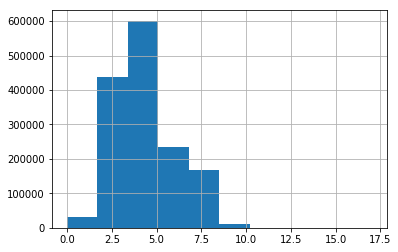

In [76]:
x_tok.name_tok.apply(lambda x:len(x)).hist()


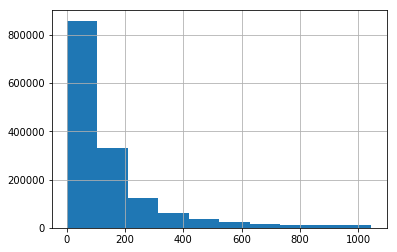

In [77]:
x_tok.item_description.apply(lambda x:len(x)).hist()


In [0]:
x_train_tok,x_valid_tok,y_train_tok,y_valid_tok=train_test_split(x_tok,y_tok)

In [0]:
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(data):
  X={
      "name":pad_sequences(data.name_tok,maxlen=10),
      "item_description":pad_sequences(data.item_description_tok,maxlen=200),
      "brand_name":np.array(data.brand_name),
      "category_name":np.array(data.category_name),
      "item_condition":np.array(data.item_condition_id),
      "shipping":np.array(data.shipping)
      }
  return X
  

In [0]:
X_train_tok=get_keras_data(x_train_tok)
X_valid_tok=get_keras_data(x_valid_tok)

In [95]:
X_train_tok["category_name"].size

1111901

### Label encoder i tf-idf na  kategoriji i brandu

In [0]:
x_tfidf=x
x_test_tfidf=test


In [0]:

le = preprocessing.LabelEncoder()

le.fit(np.hstack([x_tfidf.category_name, test.category_name]))
#le.fit(x.category_name)

x_tfidf.category_name = le.transform(x_tfidf.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([x_tfidf.brand_name, test.brand_name]))
#le.fit(x.brand_name)

x_tfidf.brand_name = le.transform(x_tfidf.brand_name)
test.brand_name = le.transform(test.brand_name)


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train_tfidf,x_valid_tfidf,y_train_tfidf,y_valid_tfidf=train_test_split(x_tfidf,y,test_size=0.03)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer


Loadanje vec fitanog vectorizera plus transformiranih featuresa

In [0]:
import pickle

In [31]:


tfidf2=pickle.load(open("tfidf.pickle", "rb"))
tfidf2_train=pickle.load(open("x_tfv_train.pickle", "rb"))
tfidf2_valid=pickle.load(open("x_tfv_valid.pickle", "rb"))




/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [32]:
tfidf2

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [0]:
tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

In [0]:
#@title
#name_i_item_descr_train=x_train_tfidf.drop(["item_condition_id","shipping","brand_name","category_name"],axis=1)

In [0]:
#@title
#list(name_i_item_descr_train.name)

In [0]:
#@title
#tfidf.fit(list(name_i_item_descr_train))

In [0]:
#@title
x_train_tfidf['item_description'].fillna(value='Missing', inplace=True)
x_train_tfidf['name'].fillna(value='Missing', inplace=True)
x_valid_tfidf['item_description'].fillna(value='Missing', inplace=True)
x_valid_tfidf['name'].fillna(value='Missing', inplace=True)


In [0]:
%%time

tfidf.fit(list(x_train_tfidf.name)+list(x_valid_tfidf.name)+list(x_valid_tfidf.item_description)+list(x_train_tfidf.item_description))

CPU times: user 4min 59s, sys: 7.81 s, total: 5min 6s
Wall time: 5min 6s


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words='english', strip_accents='unicode',
                sublinear_tf=1, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=1, vocabulary=None)

In [0]:
%%time

x_tfv_train=tfidf.transform(x_train_tfidf["item_description"],x_train_tfidf["name"])

CPU times: user 2min 16s, sys: 199 ms, total: 2min 16s
Wall time: 2min 16s
CPU times: user 2min 16s, sys: 199 ms, total: 2min 16s
Wall time: 2min 16s


In [0]:
%%time

x_tfv_valid=tfidf.transform(x_valid_tfidf["item_description"],x_valid_tfidf["name"])

CPU times: user 3.98 s, sys: 10.1 ms, total: 3.99 s
Wall time: 3.99 s
CPU times: user 3.98 s, sys: 10.1 ms, total: 3.99 s
Wall time: 3.99 s


<44477x2401707 sparse matrix of type '<class 'numpy.float64'>'
	with 1646216 stored elements in Compressed Sparse Row format>

Save vectorizera i transformacija

In [0]:
import pickle

In [0]:
pickle.dump(tfidf, open("tfidf.pickle", "wb"))


In [0]:
pickle.dump(x_tfv_train, open("x_tfv_train.pickle", "wb"))
pickle.dump(x_tfv_valid, open("x_tfv_valid.pickle", "wb"))


## Linearni model

In [0]:
y_train_tfidf=np.log1p(y_train_tfidf)

In [0]:
y_valid_tfidf=np.log1p(y_valid_tfidf)

In [0]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
import time

In [0]:
SGDReg=linear_model.SGDRegressor(max_iter=1000,tol=1e-3)

In [0]:
SGDReg

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
x_tfv_valid


<44477x2401707 sparse matrix of type '<class 'numpy.float64'>'
	with 1646216 stored elements in Compressed Sparse Row format>

In [0]:
SGDReg.fit(x_tfv_train,y_train_tfidf)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [0]:
parametri={"penalty":["none","l1","l2"],
           "alpha":[1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 0.1]}

In [0]:
grid=GridSearchCV(estimator=SGDReg,
                  param_grid=parametri,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,
                  cv=3,
                  verbose=3
                  )

In [0]:
start = time.time()
grid.fit(x_tfv_train,y_train_tfidf)
end = time.time()
print('Time to train model: %0.2fs' % (end -start))

In [0]:
model = grid.best_estimator_
print(grid.best_params_)
print(grid.best_score_)



In [0]:
#model=linear_model.SGDRegressor(max_iter=1000,tol=1e-3,penalty="none",alpha=0.05)

In [0]:
#%%time

#model.fit(x_tfv_train,y_train_tfidf)

In [0]:
y_pred=model.predict(x_tfv_valid)

In [0]:
print("rmsle=",np.sqrt(mean_squared_log_error(np.exp(y_valid_tfidf)-1, np.exp(y_pred)-1)))

In [0]:
pickle.dump(SGDReg,open("model.pickle","wb"))

In [0]:
pickle.dump(model,open("model","wb"))

In [0]:
s=pickle.load(open("SGDReg.pickle","rb"))

## Neuronske mreze

### Prvi model

In [0]:
#!pip uninstall tensorflow
#pip install tensorflow-gpu==2.0.0-alpha0


In [0]:
import tensorflow as tf
from tensorflow import keras

tf.__version__
keras.__version__

In [102]:
X_train_tok["name"].shape[1]
X_train_tok["brand_name"].shape[0]

1111901

In [0]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization

In [0]:
def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

In [0]:

def build_model(n_hidden=3,n_neurons=300,learning_rate=3e-3):
  
  #Inputs
  
  name=Input(shape=X_train_tok["name"].shape[1],name="name")
  item_description=Input(shape=X_train_tok["item_description"].shape[1],name="item_description")
  brand_name=Input(shape=[1],name="brand_name")
  item_condition=Input(shape=[1],name="item_condition")
  shipping=Input(shape=[1],name="shipping")
  
  
  concat=concatenate([Flatten()(name),
                      Flatten()(item_description),
                      Flatten()(brand_name),
                      Flatten()(item_condition),
                      Flatten()(shipping)])
  
  #layers
  
  hidden1=Dense(30,activation="relu")(concat)
  output=Dense(1,activation="linear")(hidden1)
  model=Model([name,item_description,brand_name,item_condition,shipping],output) 
  model.compile(loss="mle",optimizer="adam",metric=["mae",rmsle_cust])
  return model

In [143]:
model=build_model()

TypeError: ignored

## bzv## 

In [0]:
#!pip install wordbatch

In [0]:
#sns.heatmap(x.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
data_train,data_valid,prices_train,prices_valid=train_test_split(x,y,test_size=0.1,random_state=50)

In [0]:
#def RMS_Log_Error(prices_predicted,prices_actual):
#    err=0
#    for i in range(len(prices_predicted)):
#      err=err+(np.log(prices_predicted[i]+1)-np.log(prices_actual[i]+1))**2
#     
#   return np.sqrt(err/(len(prices_predicted)))
  

In [0]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [0]:
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfv = TfidfVectorizer(min_df=2,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')


In [0]:
tfv = TfidfVectorizer(min_df=1,  max_features=None, 
            stop_words = 'english')


In [0]:
tfv.fit(list(data_train["item_description"])+list(data_valid["item_description"]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
data_train_tfv=tfv.transform(data_train["item_description"])

In [0]:
data_train_tfv

<6x161729 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [0]:
data_train_tfv

<6x161729 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

## session save

In [0]:
# ovime sejvam konfiguraciju da ne moram ponovno sve instalirati
!pip freeze --local > /content/gdrive/My\ Drive/Mercari_colab.txt



In [0]:
#ovime loadam konfiguraciju(potrebno mountati gdrive)


#!pip install --upgrade --force-reinstall `cat/content/gdrive/My\ Drive/colab_installed.txt`